# Libaries and Import Statements:

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, accuracy_score
from torch.optim import AdamW
from transformers import AutoTokenizer, AutoModelForSequenceClassification, DataCollatorWithPadding, get_scheduler
from datasets import load_dataset
import pprint
import seaborn as sns

## Data Importation and Exploration:

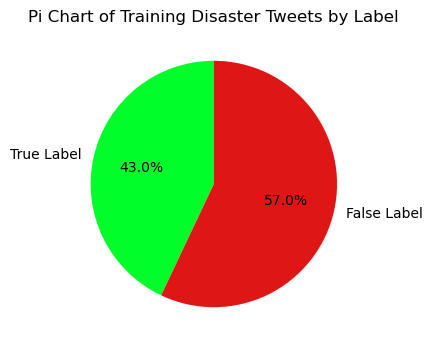

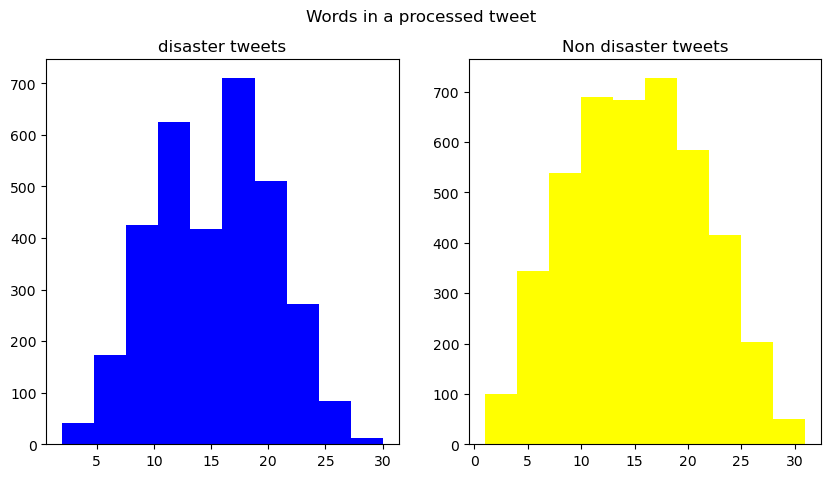

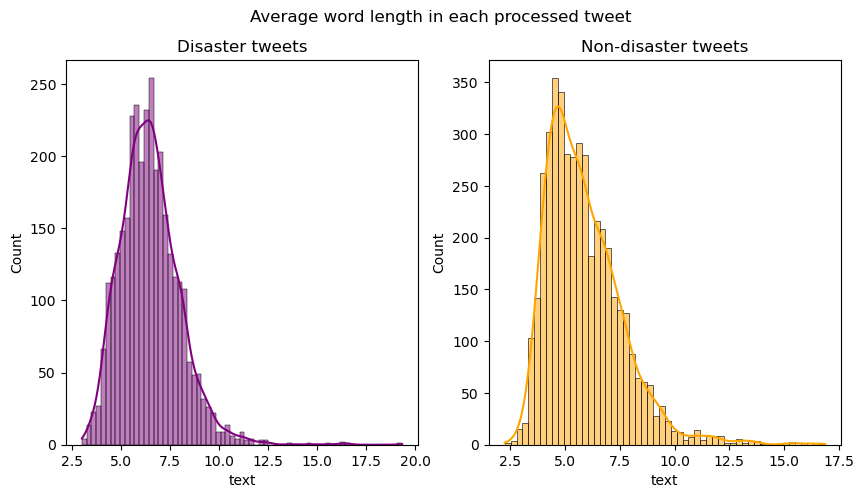

In [ ]:
df_train = pd.read_csv('F:\\disaster_tweets\\source\\train.csv')

X = df_train.text
y = df_train.target

fig = plt.figure(figsize=(6,4))
colors=["#00FF2A","#DF1616"]
pos=y[y == 1]
neg=y[y == 0]
ck=[pos.count(),neg.count()]
legpie=plt.pie(ck,labels=["True Label","False Label"],
                 autopct ='%1.1f%%', 
                 colors = colors,
                 startangle=90)
plt.title("Pi Chart of Training Disaster Tweets by Label")
plt.show()

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
tweet_len=df_train[df_train['target']==1]['text'].str.split().map(lambda x: len(x))
ax1.hist(tweet_len,color='blue')
ax1.set_title('disaster tweets')
tweet_len=df_train[df_train['target']==0]['text'].str.split().map(lambda x: len(x))
ax2.hist(tweet_len,color='yellow')
ax2.set_title('Non disaster tweets')
fig.suptitle('Words in a processed tweet')
plt.show()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Disaster tweets
word = df_train[df_train['target'] == 1]['text'].str.split().apply(lambda x: [len(i) for i in x])
sns.histplot(word.map(lambda x: np.mean(x)), kde=True, ax=ax1, color='purple')
ax1.set_title('Disaster tweets')

# Non-disaster tweets
word = df_train[df_train['target'] == 0]['text'].str.split().apply(lambda x: [len(i) for i in x])
sns.histplot(word.map(lambda x: np.mean(x)), kde=True, ax=ax2, color='orange')
ax2.set_title('Non-disaster tweets')

fig.suptitle('Average word length in each processed tweet')
plt.show()

## Ensemble Model Implementation:

#### Note:
I am very fortunate to have a very capable computer with a NVIDIA GPU. This implementation takes that in mind, and so, if you do not have a GPU on your host machine, then please be aware that this will not work for you. I am using an old GTX 1070 from early 2017, running CUDA 11.8 to produce these figures:

### Data Preperation:

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

path_train_data = r"F:\disaster_tweets\source\train.csv"
path_test_data = r"F:\disaster_tweets\source\test.csv"

dataset = load_dataset(
    "csv",
    data_files={"train": path_train_data, "test": path_test_data}
)

split = dataset["train"].train_test_split(test_size=0.2, seed=42)
train_ds = split["train"]
val_ds   = split["test"]
test_ds  = dataset["test"]

def drop_empty_text(ds):
    return ds.filter(lambda x: x["text"] is not None and x["text"].strip() != "")

train_ds = drop_empty_text(train_ds)
val_ds   = drop_empty_text(val_ds)
test_ds  = drop_empty_text(test_ds)

def convert_label(example):
    example["labels"] = int(example["target"])
    return example

train_ds = train_ds.map(convert_label)
val_ds   = val_ds.map(convert_label)


MODEL_NAMES = {"BERT":"bert-base-cased", "RoBERTa":"roberta-base"}
tokenizers = {name: AutoTokenizer.from_pretrained(m) for name, m in MODEL_NAMES.items()}

def tokenize_fn(batch, tokenizer, max_length=128):
    return tokenizer(batch["text"], truncation=True, padding="max_length", max_length=max_length)

tokenized_datasets = {}

for name, tokenizer in tokenizers.items():
    train_copy = train_ds.map(lambda x: tokenize_fn(x, tokenizer), batched=True)
    val_copy   = val_ds.map(lambda x: tokenize_fn(x, tokenizer), batched=True)
    test_copy  = test_ds.map(lambda x: tokenize_fn(x, tokenizer), batched=True)
    tokenized_datasets[name] = {"train": train_copy, "val": val_copy, "test": test_copy}

for name, tokenizer in tokenizers.items():
    train_tok = tokenized_datasets[name]["train"]
    
    def check_token_ids(dataset, tokenizer):
        for i, item in enumerate(dataset):
            if "input_ids" not in item:
                raise ValueError(f"'input_ids' not found in dataset at row {i}")
            input_ids = item["input_ids"]
            for id_ in input_ids:
                if id_ >= tokenizer.vocab_size:
                    raise ValueError(f"Token id {id_} exceeds vocab_size {tokenizer.vocab_size} at row {i}")
    
    check_token_ids(train_tok, tokenizer)

batch_size = 16
data_collators = {name: DataCollatorWithPadding(tokenizer=tokenizers[name]) for name in MODEL_NAMES.keys()}

def collate_fn(batch, name):
    filtered_batch = []
    for item in batch:
        filtered_item = {k: v for k, v in item.items() if k in ["input_ids", "attention_mask", "labels"]}
        if "token_type_ids" in item:
            filtered_item["token_type_ids"] = item["token_type_ids"]
        filtered_batch.append(filtered_item)

    collate = data_collators[name](filtered_batch)

    if "labels" in collate:
        collate["labels"] = collate["labels"].long()
    return collate

train_loaders = {
    name: DataLoader(
        tokenized_datasets[name]["train"],
        batch_size=batch_size,
        shuffle=True,
        collate_fn=lambda batch, name=name: collate_fn(batch, name)
    )
    for name in MODEL_NAMES.keys()
}

val_loaders = {
    name: DataLoader(
        tokenized_datasets[name]["val"],
        batch_size=batch_size,
        shuffle=False,
        collate_fn=lambda batch, name=name: collate_fn(batch, name)
    )
    for name in MODEL_NAMES.keys()
}

test_loaders = {
    name: DataLoader(
        tokenized_datasets[name]["test"],
        batch_size=batch_size,
        shuffle=False,
        collate_fn=lambda batch, name=name: collate_fn(batch, name)
    )
    for name in MODEL_NAMES.keys()
}

Device: cuda


Map: 100%|██████████| 3263/3263 [00:00<00:00, 21330.01 examples/s]


### LSTM Implementation:

In [4]:
class LSTMDataset(Dataset):
    def __init__(self, texts, labels=None, tokenizer=None, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        tokens = self.tokenizer(text, truncation=True, padding='max_length',
                                max_length=self.max_len, return_tensors='pt')
        text_tensor = tokens['input_ids'].squeeze()
        length = (text_tensor != 0).sum()
        label = torch.tensor(self.labels[idx], dtype=torch.float) if self.labels is not None else torch.tensor(0.0)
        return text_tensor, length, label

lstm_tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
train_df = pd.DataFrame(train_ds)
val_df   = pd.DataFrame(val_ds)
test_df  = pd.DataFrame(test_ds)

train_lstm_dataset = LSTMDataset(train_df["text"].tolist(), train_df["target"].tolist(), tokenizer=lstm_tokenizer)
val_lstm_dataset   = LSTMDataset(val_df["text"].tolist(), val_df["target"].tolist(), tokenizer=lstm_tokenizer)
test_lstm_dataset  = LSTMDataset(test_df["text"].tolist(), labels=None, tokenizer=lstm_tokenizer)

train_lstm_loader = DataLoader(train_lstm_dataset, batch_size=batch_size, shuffle=True)
val_lstm_loader   = DataLoader(val_lstm_dataset, batch_size=batch_size, shuffle=False)
test_lstm_loader  = DataLoader(test_lstm_dataset, batch_size=batch_size, shuffle=False)

class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim=100, hidden_dim=64, output_dim=1, n_layers=2, bidirectional=True, dropout=0.2):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers=n_layers, bidirectional=bidirectional,
                            dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_dim*2, output_dim)
        self.act = nn.Sigmoid()

    def forward(self, text, lengths):
        embedded = self.embedding(text)
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)
        packed_output, (hidden, cell) = self.lstm(packed_embedded)
        hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
        dense_outputs = self.fc(hidden)
        return self.act(dense_outputs).squeeze()

vocab_size = lstm_tokenizer.vocab_size
lstm_model = LSTMClassifier(vocab_size=vocab_size).to(device)
criterion_lstm = nn.BCELoss()
optimizer_lstm = optim.Adam(lstm_model.parameters(), lr=1e-4)

def train_lstm_epoch(model, loader, criterion, optimizer):
    model.train()
    total_loss, all_preds, all_labels = 0, [], []
    for texts, lengths, labels in loader:
        texts, lengths, labels = texts.to(device), lengths.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(texts, lengths)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        all_preds.extend((outputs>=0.5).int().cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    return total_loss/len(loader), acc, f1

def eval_lstm_epoch(model, loader, criterion):
    model.eval()
    total_loss, all_preds, all_labels = 0, [], []
    with torch.no_grad():
        for texts, lengths, labels in loader:
            texts, lengths, labels = texts.to(device), lengths.to(device), labels.to(device)
            outputs = model(texts, lengths)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            all_preds.extend((outputs>=0.5).int().cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    return total_loss/len(loader), acc, f1

### Transformer Implementation (BERT + RoBERTa):

In [5]:
def train_transformer_epoch(model, loader, optimizer, scheduler=None):
    model.train()
    total_loss, all_preds, all_labels = 0, [], []
    for batch in loader:
        batch = {k:v.to(device) for k,v in batch.items()}
        optimizer.zero_grad()
        outputs = model(**batch)
        loss = outputs.loss
        logits = outputs.logits
        preds = torch.argmax(logits, dim=-1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch["labels"].cpu().numpy())
        loss.backward()
        optimizer.step()
        if scheduler: scheduler.step()
        total_loss += loss.item()
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    return total_loss/len(loader), acc, f1

def eval_transformer_epoch(model, loader):
    model.eval()
    total_loss, all_preds, all_labels = 0, [], []
    with torch.no_grad():
        for batch in loader:
            batch = {k:v.to(device) for k,v in batch.items()}
            outputs = model(**batch)
            loss = outputs.loss
            logits = outputs.logits
            preds = torch.argmax(logits, dim=-1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch["labels"].cpu().numpy())
            total_loss += loss.item()
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    return total_loss/len(loader), acc, f1

EPOCHS_LSTM = 5
EPOCHS_TRANSFORMER = 5

results = {name:{"train_loss":[],"train_acc":[],"train_f1":[],"val_loss":[],"val_acc":[],"val_f1":[]} for name in ["LSTM","BERT","RoBERTa","Ensemble"]}

### Training Loops: 

In [6]:

# --- LSTM Training ---
for epoch in range(EPOCHS_LSTM):
    train_loss, train_acc, train_f1 = train_lstm_epoch(lstm_model, train_lstm_loader, criterion_lstm, optimizer_lstm)
    val_loss, val_acc, val_f1 = eval_lstm_epoch(lstm_model, val_lstm_loader, criterion_lstm)
    results["LSTM"]["train_loss"].append(train_loss)
    results["LSTM"]["train_acc"].append(train_acc)
    results["LSTM"]["train_f1"].append(train_f1)
    results["LSTM"]["val_loss"].append(val_loss)
    results["LSTM"]["val_acc"].append(val_acc)
    results["LSTM"]["val_f1"].append(val_f1)
    print(f"LSTM Epoch {epoch+1} | Train F1: {train_f1:.4f} | Val F1: {val_f1:.4f}")

# --- Transformers Training ---
transformer_models = {}
for name, model_name in MODEL_NAMES.items():
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2).to(device)
    optimizer = AdamW(model.parameters(), lr=2e-5)
    num_training_steps = EPOCHS_TRANSFORMER * len(train_loaders[name])
    scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)
    transformer_models[name] = model

    for epoch in range(EPOCHS_TRANSFORMER):
        train_loss, train_acc, train_f1 = train_transformer_epoch(model, train_loaders[name], optimizer, scheduler)
        val_loss, val_acc, val_f1 = eval_transformer_epoch(model, val_loaders[name])
        results[name]["train_loss"].append(train_loss)
        results[name]["train_acc"].append(train_acc)
        results[name]["train_f1"].append(train_f1)
        results[name]["val_loss"].append(val_loss)
        results[name]["val_acc"].append(val_acc)
        results[name]["val_f1"].append(val_f1)
        print(f"{name} Epoch {epoch+1} | Train F1: {train_f1:.4f} | Val F1: {val_f1:.4f}")

LSTM Epoch 1 | Train F1: 0.0075 | Val F1: 0.0122
LSTM Epoch 2 | Train F1: 0.4935 | Val F1: 0.5896
LSTM Epoch 3 | Train F1: 0.6364 | Val F1: 0.6333
LSTM Epoch 4 | Train F1: 0.6892 | Val F1: 0.6540
LSTM Epoch 5 | Train F1: 0.7250 | Val F1: 0.6403


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BERT Epoch 1 | Train F1: 0.7451 | Val F1: 0.7924
BERT Epoch 2 | Train F1: 0.8437 | Val F1: 0.7882
BERT Epoch 3 | Train F1: 0.9071 | Val F1: 0.7772
BERT Epoch 4 | Train F1: 0.9438 | Val F1: 0.7743


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BERT Epoch 5 | Train F1: 0.9586 | Val F1: 0.7664
RoBERTa Epoch 1 | Train F1: 0.7454 | Val F1: 0.7919
RoBERTa Epoch 2 | Train F1: 0.8338 | Val F1: 0.7951
RoBERTa Epoch 3 | Train F1: 0.8754 | Val F1: 0.7942
RoBERTa Epoch 4 | Train F1: 0.9132 | Val F1: 0.7754
RoBERTa Epoch 5 | Train F1: 0.9409 | Val F1: 0.7760


### Ensemble Prediction (Soft-voting):

In [7]:
def predict_ensemble(lstm_model, transformers, lstm_loader, transformer_loaders):
    lstm_model.eval()
    for m in transformers.values(): m.eval()

    # LSTM predictions
    lstm_probs = []
    with torch.no_grad():
        for texts, lengths, _ in lstm_loader:
            texts, lengths = texts.to(device), lengths.to(device)
            lstm_probs.append(lstm_model(texts, lengths).detach().cpu())
    lstm_probs = torch.cat(lstm_probs)

    # Transformer predictions
    transformer_probs = []
    for name, model in transformers.items():
        loader = transformer_loaders[name]
        probs = []
        with torch.no_grad():
            for batch in loader:
                batch = {k:v.to(device) for k,v in batch.items() if k!="labels"}
                logits = model(**batch).logits[:,1]
                probs.append(logits.detach().cpu())
        transformer_probs.append(torch.cat(probs))

    transformer_probs_avg = torch.stack(transformer_probs).mean(dim=0)
    ensemble_probs = (lstm_probs + transformer_probs_avg)/2
    ensemble_preds = (ensemble_probs>=0.5).int().numpy()
    return ensemble_preds, ensemble_probs.numpy()

ensemble_preds, ensemble_probs = predict_ensemble(lstm_model, transformer_models, val_lstm_loader, val_loaders)
results["Ensemble"]["val_f1"].append(f1_score(val_df["target"], ensemble_preds))
results["Ensemble"]["val_acc"].append(accuracy_score(val_df["target"], ensemble_preds))

### Plotting Function & Plots:

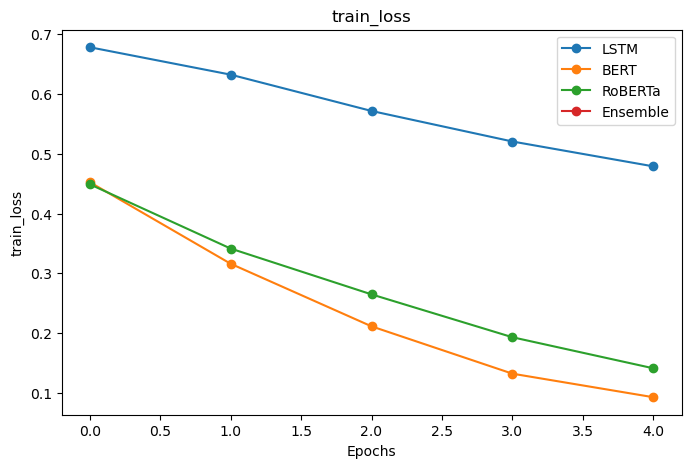

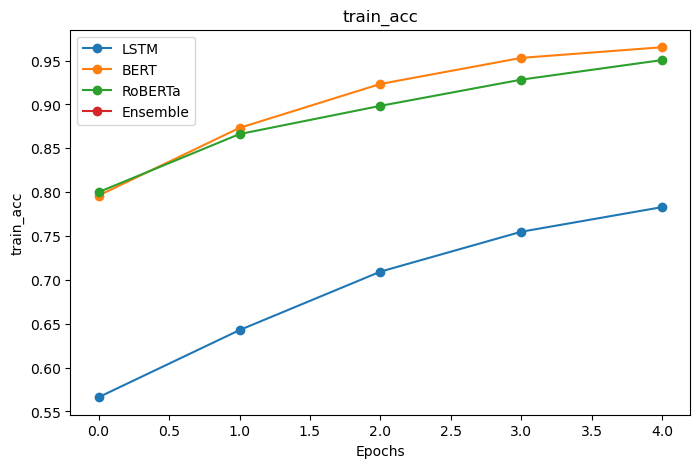

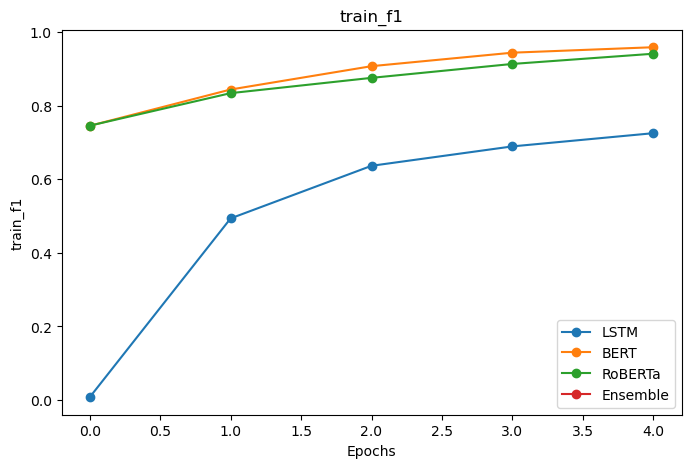

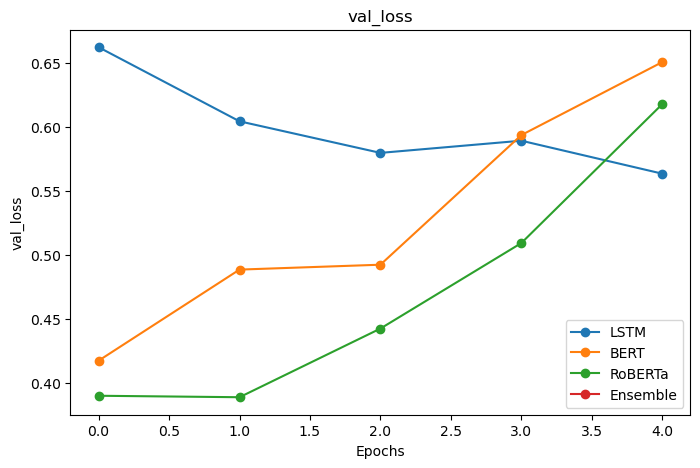

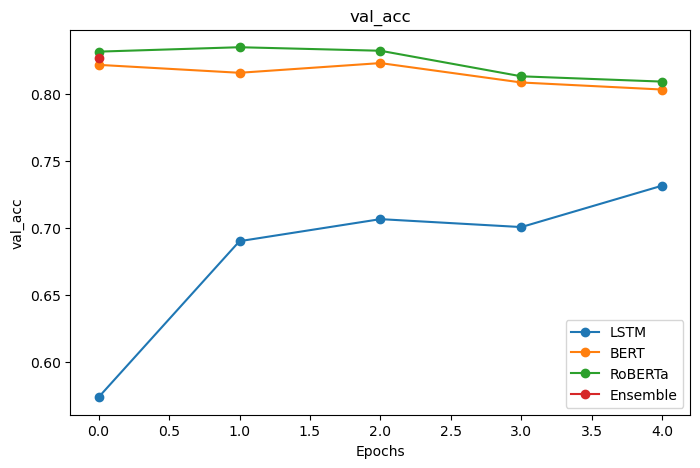

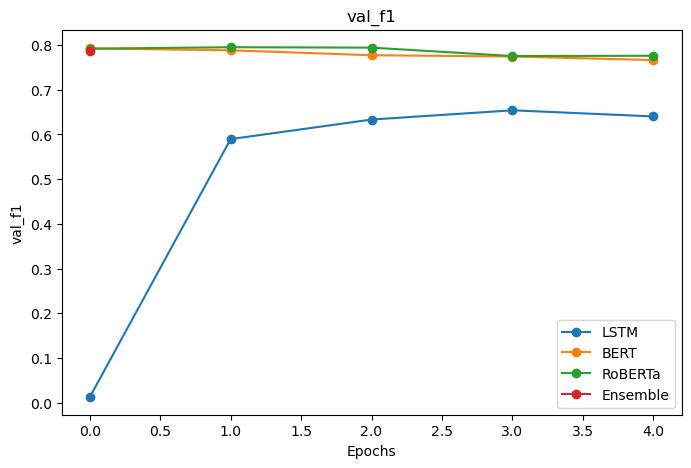

In [8]:

def plot_metrics(results):
    metrics = ["train_loss","train_acc","train_f1","val_loss","val_acc","val_f1"]
    for metric in metrics:
        plt.figure(figsize=(8,5))
        for model_name in results.keys():
            if metric in results[model_name]:
                plt.plot(results[model_name][metric], marker='o', label=model_name)
        plt.title(metric)
        plt.xlabel("Epochs")
        plt.ylabel(metric)
        plt.legend()
        # plt.savefig(f'F:\disaster_tweets\plots\performance\{model_name}_{metric}.png', dpi=1200, bbox_inches='tight')
        plt.show()

plot_metrics(results)